In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from datetime import datetime, date
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

In [3]:
FILES_DIR = './files/'
Eco_df = pd.read_csv(FILES_DIR + 'Eco_df.csv')

In [4]:
Eco_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
Eco_df.columns

Index(['session_id', 'event_timestamp', 'event_name', 'user_no', 'item_no',
       'device_type', 'country', 'region', 'platform', 'rating', 'birth_date',
       'gender', 'age', 'item_name', 'image_name', 'price', 'category1_code',
       'category1_name', 'category2_code', 'category2_name', 'category3_code',
       'category3_name', 'brand_no', 'brand_name', 'dayname', 'korea',
       'cor_cat1', 'cor_region', 'Hour', 'time_1', 'time_2', 'time_3'],
      dtype='object')

In [6]:
session_id = [(list(set(x['item_no'].values))[0], '/'.join(x['session_id'].values)) for index, x in Eco_df.groupby('item_no')]
session_id_df = pd.DataFrame(data=session_id, columns=['item_no', 'session_id'])
session_id_df = session_id_df.set_index('item_no')

user_no = [(list(set(x['item_no'].values))[0], '/'.join(x['user_no'].values)) for index, x in Eco_df.groupby('item_no')]
user_no_df = pd.DataFrame(data=user_no, columns=['item_no', 'user_no'])
user_no_df = user_no_df.set_index('item_no')

device_type_group = [(list(set(x['item_no'].values))[0], '/'.join(x['device_type'].values)) 
                     for index, x in Eco_df.groupby('item_no')]
device_type_group_df = pd.DataFrame(data=device_type_group, columns=['item_no', 'device_type'])
device_type_group_df = device_type_group_df.set_index('item_no')

country_group = [(list(set(x['item_no'].values))[0], '/'.join(x['country'].values)) 
                 for index, x in Eco_df.groupby('item_no')]
country_group_df = pd.DataFrame(data=country_group, columns=['item_no', 'country'])
country_group_df = country_group_df.set_index('item_no')

gender = [(list(set(x['item_no'].values))[0], ','.join(x['gender'].values)) for index, x in Eco_df.groupby('item_no')]
gender_df = pd.DataFrame(data=gender, columns=['item_no', 'gender'])
gender_df = gender_df.set_index('item_no')

platform = [(list(set(x['item_no'].values))[0], ','.join(x['platform'].values)) for index, x in Eco_df.groupby('item_no')]
platform_df = pd.DataFrame(data=platform, columns=['item_no', 'platform'])
platform_df = platform_df.set_index('item_no')

age_group = [(list(set(x['item_no'].values))[0], ','.join(x['age'].astype(str).values)) for index, x in Eco_df.groupby('item_no')]
age_group_df = pd.DataFrame(data=age_group, columns=['item_no', 'age'])
age_group_df = age_group_df.set_index('item_no')

price_group = [(list(set(x['item_no'].values))[0], ','.join(x['price'].astype(str).values)) for index, x in Eco_df.groupby('item_no')]
price_group_df = pd.DataFrame(data=price_group, columns=['item_no', 'price'])
price_group_df = price_group_df.set_index('item_no')

cat1_group = [(list(set(x['item_no'].values))[0], ','.join(x['category1_name'].values)) 
               for index, x in Eco_df.groupby('item_no')]
cat1_group_df = pd.DataFrame(data=cat1_group, columns=['item_no', 'category1_name'])
cat1_group_df = cat1_group_df.set_index('item_no')

cat2_group = [(list(set(x['item_no'].values))[0], ','.join(x['category2_name'].values)) 
               for index, x in Eco_df.groupby('item_no')]
cat2_group_df = pd.DataFrame(data=cat2_group, columns=['item_no', 'category2_name'])
cat2_group_df = cat2_group_df.set_index('item_no')

# day_group = [(list(set(x['item_no'].values))[0], ','.join(x['day_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# day_group_df = pd.DataFrame(data=day_group, columns=['item_no', 'day_group'])
# day_group_df = day_group_df.set_index('item_no')

# korea_group = [(list(set(x['item_no'].values))[0], ','.join(x['korea_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# korea_group_df = pd.DataFrame(data=korea_group, columns=['item_no', 'korea_group'])
# korea_group_df = korea_group_df.set_index('item_no')

# corr_cat_group = [(list(set(x['item_no'].values))[0], ','.join(x['corr_cat_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# corr_cat_group_df = pd.DataFrame(data=corr_cat_group, columns=['item_no', 'corr_cat_group'])
# corr_cat_group_df = corr_cat_group_df.set_index('item_no')

# corr_region_group = [(list(set(x['item_no'].values))[0], ','.join(x['corr_region_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# corr_region_group_df = pd.DataFrame(data=corr_region_group, columns=['item_no', 'corr_region_group'])
# corr_region_group_df = corr_region_group_df.set_index('item_no')

# hour_group = [(list(set(x['item_no'].values))[0], ','.join(x['hour_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# hour_group_df = pd.DataFrame(data=hour_group, columns=['item_no', 'hour_group'])
# hour_group_df = hour_group_df.set_index('item_no')

# time1_group = [(list(set(x['item_no'].values))[0], ','.join(x['time1_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# time1_group_df = pd.DataFrame(data=time1_group, columns=['item_no', 'time1_group'])
# time1_group_df = time1_group_df.set_index('item_no')

# time2_group = [(list(set(x['item_no'].values))[0], ','.join(x['time2_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# time2_group_df = pd.DataFrame(data=time2_group, columns=['item_no', 'time2_group'])
# time2_group_df = time2_group_df.set_index('item_no')

# time3_group = [(list(set(x['item_no'].values))[0], ','.join(x['time3_group'].values)) 
#                for index, x in Eco_df.groupby('item_no')]
# time3_group_df = pd.DataFrame(data=time3_group, columns=['item_no', 'time3_group'])
# time3_group_df = time3_group_df.set_index('item_no')


In [7]:
total_df = pd.merge(session_id_df, user_no_df, on='item_no', how='inner')
total_df = pd.merge(total_df, device_type_group_df, on='item_no', how='inner')
total_df = pd.merge(total_df, country_group_df, on='item_no', how='inner')
total_df = pd.merge(total_df, gender_df, on='item_no', how='inner')
total_df = pd.merge(total_df, platform_df, on='item_no', how='inner')
total_df = pd.merge(total_df, age_group_df, on='item_no', how='inner')
total_df = pd.merge(total_df, price_group_df, on='item_no', how='inner')
total_df = pd.merge(total_df, cat1_group_df, on='item_no', how='inner')
total_df = pd.merge(total_df, cat2_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, day_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, korea_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, corr_cat_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, corr_region_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, hour_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, time1_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, time2_group_df, on='item_no', how='inner')
# total_df = pd.merge(total_df, time3_group_df, on='item_no', how='inner')

print(total_df.shape)

(12400, 10)


In [8]:
dummy1 = total_df['session_id'].str.get_dummies(sep=',')

dummy2 = total_df['user_no'].str.get_dummies(sep=',')

dummy3 = total_df['device_type'].str.get_dummies(sep=',')

dummy4 = total_df['country'].str.get_dummies(sep=',')

dummy5 = total_df['platform'].str.get_dummies(sep=',')

dummy6 = total_df['gender'].str.get_dummies(sep=',')

dummy7 = total_df['age'].str.get_dummies(sep=',')

dummy8 = total_df['price'].str.get_dummies(sep=',')

dummy9 = total_df['category1_name'].str.get_dummies(sep=',')

dummy10 = total_df['category2_name'].str.get_dummies(sep=',')

# dummy11 = total_df['dayname'].str.get_dummies(sep=',')

# dummy12 = total_df['korea'].str.get_dummies(sep=',')

# dummy13 = total_df['cor_cat1'].str.get_dummies(sep=',')

# dummy14 = total_df['cor_region'].str.get_dummies(sep=',')

# dummy15 = total_df['Hour'].str.get_dummies(sep=',')

# dummy16 = total_df['time_1'].str.get_dummies(sep=',')

# dummy17 = total_df['time_2'].str.get_dummies(sep=',')

# dummy18 = total_df['time_3'].str.get_dummies(sep=',')

In [9]:
train_df, test_df = train_test_split(Eco_df, test_size=0.25, random_state=42)

print(train_df.shape)
print(test_df.shape)

(12276, 32)
(4093, 32)


In [11]:
y_train = train_df['rating']
print(y_train.shape)

(12276,)


In [40]:
X_train = pd.concat([pd.get_dummies(train_df['user_no'], prefix='user_no'),
        #    train_df['item_no'].apply(lambda x: dummy1.loc[x]),
           train_df['item_no'].apply(lambda x: dummy2.loc[x])], axis=1)
        #    train_df['item_no'].apply(lambda x: dummy3.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy4.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy5.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy6.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy7.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy8.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy9.loc[x]),
        #    train_df['item_no'].apply(lambda x: dummy10.loc[x])], axis=1)

In [41]:
X_train

,user_no_++GVOXP4cXADbykjQID0Xw==,user_no_++KVqHvNPHvp3LL9SkuL8A==,user_no_++KjBls4euaEX77FWJaZ/A==,user_no_++atyTNHXYg0581SrQtv4g==,user_no_++cSWarDRlxMrxzr70CDpQ==,user_no_++hK92KjjWxhaH5fVgRFww==,user_no_++zm1SfGW/fM0zoem4Z2Vw==,user_no_+/4bsFMiFB+MVYuGPycOcg==,user_no_+/RLkyZzk5HXyPRaMnegbg==,user_no_+/aifvuZwuhpIlZr6EbCwA==,...,zxlfe7oZ1hPumx7y3MAxwQ==/5aqzUOYbWEEV61TyHuxtvQ==/q1UeIk5LleUvEe+gNfJPug==/Tu0/64UI/usipD8MHSuPrg==,zyNrne/GgW7Ox0ZqBjETHQ==,zyNrne/GgW7Ox0ZqBjETHQ==/wXt98hY7WR85x6mJsijoxA==,zygWFtOw4IuHCzuQzNqjBg==,zz5d8kbLWcW4sbp9upVPJg==,zzLGF7vXyODnAkQWIcqX0g==,zzRmXD4euBIgVdoULWFZzQ==,zzcn+ZKhRpwZM6NzvINwbQ==,zzfEuQ53V3+8n5U/oiz09w==/Z5s/sVbhXYOwAqXEW38xTg==,zzij36tc9ArXw9zsShsATA==
10436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
import scipy
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

In [44]:
x = Eco_df.copy()
y = Eco_df['user_no']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [51]:
import scipy
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

In [34]:
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)


# Update gradients
def sgd(X, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss




def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])

    # gradient update할 때, summed는 독립이므로 re-use 가능
    return pred, summed




# Train Factorization Machine
# X -> sparse csr_matrix, y -> label
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features) # -> w
    global_bias = 0.0 # -> w0
    
    # latent factors for all features -> v
    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples, num_features,
                            global_bias, weights,
                            feature_factors, num_factors,
                            learning_rate, reg_weights, reg_features)
        print(f'[epoch: {epoch+1}], loss: {loss}')

        epoch_loss.append(loss)
      
    return epoch_loss


In [35]:
config = {
    "num_epochs": 10,
    "num_factors": 10,
    "learning_rate": 0.1,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [36]:
epoch_loss = fit(X_train_sparse, y_train.values, config)

[epoch: 1], loss: 0.19898322782544844
[epoch: 2], loss: 0.20397133288400454
[epoch: 3], loss: 0.206245072677414
[epoch: 4], loss: 0.2065379149780845
[epoch: 5], loss: 0.20586874541927663
[epoch: 6], loss: 0.20492171654358263
[epoch: 7], loss: 0.20385254709864278
[epoch: 8], loss: 0.20272119818031228
[epoch: 9], loss: 0.2015564892749194
[epoch: 10], loss: 0.20037455808646285


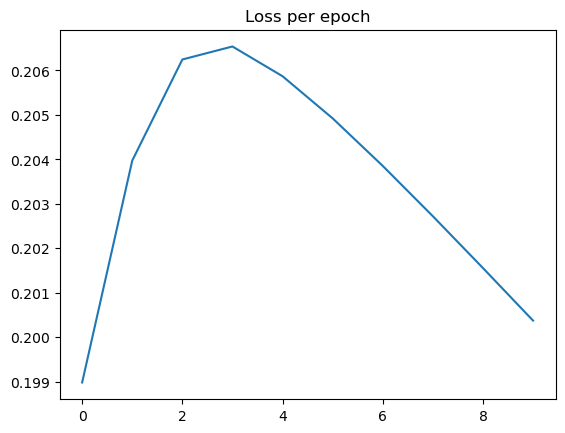

In [37]:
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()